<a href="https://colab.research.google.com/github/tummalapallimurali/GenAI/blob/main/Fine_tune_LLMs_on_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finetune LLMs for Free: A Step-by-Step Open-Source Tutorial**

**Welcome to this tutorial!** In the following steps, we will show you how to fine-tune the llama-2 7B LLM for **Question Answering** on your own private data. Simply run the cells sequentially, to learn how to load the model and your data, train the model, and finally ask questions about your data.

### Why would this tutorial be helpful for you?

Our tutorial to fine-tune llama 2 uniquely offers several advantages over others currently out in the internet, namely:

1. The ability to **fine-tune on freeform text articles and documents**; we don't assume you manually format your data in well defined formats like CSV, JSON, etc.

2. Offer **greater degree of control** and **in-depth explanations** to users on tuning parameters to **optimize performance of fine-tuned model** specific for your use case

3. Provide a **walkthrough of fine-tuning Llama-2 with high accuracy and demonstration** of this model based on a **realistic use case**.

#### Authors and Credits

[Sri Ranganathan Palaniappan](https://www.linkedin.com/in/sri-ranganathan-palaniappan/), CS undergrad student at Georgia Tech.

[Mansi Phute](https://www.linkedin.com/in/mansi-phute-413744166/),  CS masters student at Georgia Tech

[Seongmin Lee](https://www.linkedin.com/in/seongmin-lee-8b8a97209/),  CS PhD student at Georgia Tech

[Polo Chau](https://www.linkedin.com/in/polochau/),  Associate Professor at Georgia Tech.

**Memory requirements: How many GPU(s) to use?**

This tutorial needs no more than 14GB GPU RAM. Depending on the GPU you’re using, one GPU may be sufficient (e.g., NVIDIA RTX 4090 has 24GB RAM). Modify the code below to specify the number of GPUs to use.

Refer to this [medium post](https://medium.com/polo-club-of-data-science/memory-requirements-for-fine-tuning-llama-2-80f366cba7f5) to learn more about the memory requirements for finetuning Llama-2-7B!

**Note: If you're using Google Colab, the code below automatically sets the GPU to T4.**

In [1]:
!pip install GPUtil

import torch
import GPUtil
import os

GPUtil.showUtilization()

if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU not available.")

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# Change if needed to accomodate memory requirements!
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the GPU ID (0 for T4)

!nvidia-smi # Verify notebook is running on a GPU

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=5fa5cc2087f867d1f6bf76c1cc8d6d808a2e9998bc96eec04c1c487f825d71b6
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU is available!
Mon Jan 20 16:03:05 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=============================

## Import Libraries

Execute the cell below to import the necessary libraries for fine-tuning Llama-2.

**Note:** *You only need to run this cell once initially, and you can then comment it out.*


In [2]:
# #!pip install -q git+https://github.com/huggingface/peft.git
# !pip install -q -i https://pypi.org/simple/ bitsandbytes
# #!pip install -q transformers==4.30
# !pip install -q datasets
# !pip install --upgrade transformers

import torch
import os
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig,LlamaTokenizer
from huggingface_hub import notebook_login
from datasets import load_dataset
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from datetime import datetime

if 'COLAB_GPU' in os.environ:
    from google.colab import output
    output.enable_custom_widget_manager()

## **Load and Configure Model**

**Since Llama-2 is a gated model, do the following steps to get access to the model:**

**1. Create an account in HuggingFace [here](https://huggingface.co/join)**

**2. Request access to the [Llama-2-7b-chat model here](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf).**

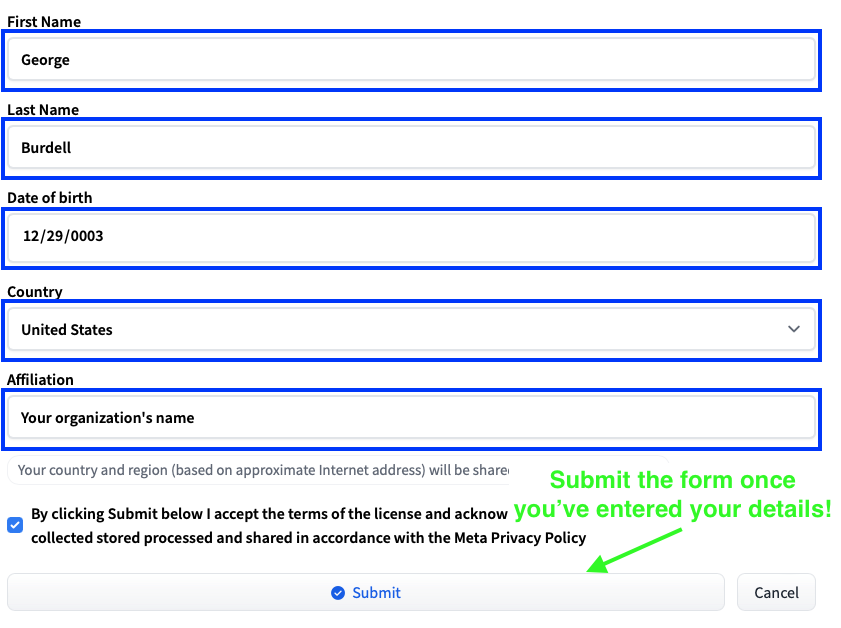

**Once you fill out the form as instructed above, you should get an email confirmation granting access to the model. You're good to proceed with the tutorial!**

We load the model from Hugging Face using **4-bit quantization** with the [`BitsAndBytesConfig`](https://huggingface.co/docs/transformers/main_classes/quantization#transformers.BitsAndBytesConfig)
 from the Hugging Face Transformers library.


In [3]:
if 'COLAB_GPU' in os.environ:
    !huggingface-cli login
else:
    notebook_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `causalmodel` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `causalmodel`

In [4]:
base_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

'''
NOTE:


load_in_4bit: Enables loading the model using 4-bit quantization, reducing
memory and computational costs.

bnb_4bit_compute_dtype: Sets the computational data type for the 4-bit quantized
model, controlling precision during inference or training.
'''

model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                             quantization_config=bnb_config)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

## Loading datasets for training

<!-- For fine-tuning Llama-2-7b-chat model on your own private data, depending on the usecases, the format of your input data plays a significant role in the training process. In this guide, we'll explore two common formats for organizing your data: **JSON for structured data and text (.txt) for unstructured data**. -->

<!-- ### **Option 1: Structured Data (JSON Format)**

JSON formatted input data provides a structured format consisting of question-answer pairs. Each datapoint (each line) consists of a question and its corresponding answer, allowing for clear and explicit mapping of question-answer pairs. This format is ideal for scenarios where data is neatly organized and follows a predictable structure.

**Pros:**
- Clear and organized structure, resulting in better training results.
- Explicit mapping for question with corresponding answer.
- Suitable for datasets with consistent formatting.

**Cons:**
- Labor intensive: requires additional processing to convert unstructured data into a structured format.
- Less flexible for datasets with varying or irregular structures. -->

<!-- ### **Loading data as multiple .txt files** -->
### **Unstructured Data (Text Format)**

**Pros:**
- Flexible with diverse data formats with irregular structures, not limited to Question-Answer pairs.
- Can contain blocks of text from guides/articles or multiple Q&A pairs.
- Simple to create and modify; offers enhanced readability and reduced labor intensity.

**Cons:**
- Compared to JSON format, offers less structured data, potentially resulting in inferior training outcomes.


All of our training data are formatted as **multiple .txt files**.


`train_dataset`: *Important for model training, this dataset contains the training data used to update the model’s weights through backpropagation.*

We have provided example training .txt files cloned from a github repository that shows how your private data may be formatted.

In [5]:
!git clone https://github.com/poloclub/Fine-tuning-LLMs.git

if 'COLAB_GPU' in os.environ:
    dir_path = '/content/Fine-tuning-LLMs/data/'
else:
    dir_path = 'Fine-tuning-LLMs/data/'

os.chdir(dir_path)

train_dataset = load_dataset("text", data_files={"train":
                ["hawaii_wf_1.txt", "hawaii_wf_2.txt",
                 "hawaii_wf_3.txt","hawaii_wf_4.txt",
                 "hawaii_wf_5.txt","hawaii_wf_6.txt",
                 "hawaii_wf_7.txt","hawaii_wf_8.txt",
                "hawaii_wf_9.txt","hawaii_wf_10.txt","hawaii_wf_11.txt"]}, split='train')

os.chdir('..')
os.chdir('..')

Cloning into 'Fine-tuning-LLMs'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 47 (delta 14), reused 29 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 9.34 MiB | 8.24 MiB/s, done.
Resolving deltas: 100% (14/14), done.


Generating train split: 0 examples [00:00, ? examples/s]

### **Initialize & configure tokenizer**

We have set `add_eos_token = True` so that the model knows how to recognize the “end of sentence". We have also added a special pad token `'[PAD]'` to pad shorter lines to match the length of longer ones.

In [6]:
tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
                                           trust_remote_code=True,
                                           add_eos_token=True)

'''
We initialize the Llama tokenizer (slow) for the Llama-2-7b-chat model.
The Llama tokenizer is known to have issues with automatically setting
the End-of-sentence (eos) token and the padding (pad) token.
'''

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# set the pad token to indicate that it's the end-of-sentence
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

### **Tokenize Prompt for formatted data**

We tokenize—converting text into numbers to make it understandable for LLMs—our training dataset using the code below:


In [7]:
tokenized_train_dataset=[]
for phrase in train_dataset:
    tokenized_train_dataset.append(tokenizer(phrase['text']))

### ***Bonus Option: Structured data (JSONL format)***

*You can also finetune your model on structured data which is formatted as JSONL files! Each datapoint (each line) consists of a question and its corresponding answer, allowing for clear and explicit mapping of question-answer pairs, thus leading to **better training results**.*

*Each line is a datapoint that is formatted as:*

```json
{'Question': 'Your question goes here', 'Answer': 'Your answer goes here'}
```

*However, this format is **labor intensive and only ideal for scenarios where data is exclusively Q&A pairs** neatly organized and follows a predictable structure.*

In [ ]:
########## UNCOMMENT CODE BELOW IF INPUT DATA IS JSONL FILES ##########

### Load dataset

# from datasets import load_dataset

# train_dataset = load_dataset("json", data_files={"train":
#   ["serviceNowQA_training.jsonl"]}, split="train")

# def formatInputJSONData(datapoint):
#     text = f"{datapoint['Question']}\n{datapoint['Answer']}"
#     return text

### Tokenize data

# tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
#    trust_remote_code=True, add_eos_token=True)

# if tokenizer.pad_token is None:
#     tokenizer.add_special_tokens({'pad_token': '[PAD]'})

### Tokenize prompt

# def tokenizePrompt(prompt):
#     currPrompt = formatInputJSONData(prompt)
#     return tokenizer(currPrompt)

# tokenized_train_dataset = train_dataset.map(tokenizePrompt)

########## UNCOMMENT CODE ABOVE IF INPUT DATA IS JSONL FILES ##########

### **PEFT Fine-Tuning**

We now prepare the model for knowledge distillation training using the **PEFT (Parameter-Efficient Fine-Tuning)** method to significantly reduce the memory and compute requirements.


In [8]:
# gradient checkpointing to reduce memory usage for increased compute time
model.gradient_checkpointing_enable()

# compressing the base model into a smaller, more efficient model
model = prepare_model_for_kbit_training(model)

### Configure model with LoRA

The code below uses [LoRA](https://huggingface.co/docs/diffusers/en/training/lora) (a PEFT method) to reduce the number of trainable parameters. LoRA works by decomposing the large matrix of the pre-trained model into two smaller low-rank matrices in the attention layers which drastically reduces the number of parameters that need to be fine-tuned. Refer to the __[LoRA documentation](https://opendelta.readthedocs.io/en/latest/modules/deltas.html#lora)__ to learn more about the parameters and use cases.

In [9]:
config = LoraConfig(
    # rank of the update matrices
    # Lower rank results in smaller matrices with fewer trainable params
    r=8,

    # impacts low-rank approximation aggressiveness
    # increasing value speeds up training
    lora_alpha=64,

    # modules to apply the LoRA update matrices
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "gate_proj",
        "down_proj",
        "up_proj",
        "o_proj"
    ],

    # determines LoRA bias type, influencing training dynamics
    bias="none",

    # regulates model regularization; increasing may lead to underfitting
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

## Training the model

We're now ready to train our Llama 2 model on our new data! We'll be using the [`Transformers`](https://huggingface.co/docs/transformers/en/index) library to create a [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) object for training the model. The `Trainer` takes the pre-trained model, training datasets, training arguments, and data collator as input.

Training time depends on the size of the training data, number of epochs and the configuration of the GPU used. If you run the below cell using the sample dataset provided on Google Colab T4 GPU (default), then it should take around **1 hour 30 minutes to complete training** for 3 epochs of the provided sample Hawaii wildfire dataset.

In [10]:
### TWO IMPORTANT TRAINING PARAMETERS TO CONSIDER CHANGING

train_epochs_val = 3 # CHANGE VALUE AS NEEDED HERE!
'''
train_epochs_val is the times the model will iterate over the entire training
dataset. Increasing the value may allow the model to learn more from the data,
but be cautious of overfitting.
'''

learning_rate_val = 1e-4 # CHANGE VALUE AS NEEDED HERE!
'''
A higher learning_rate_val can lead to faster convergence, but it might
overshoot the optimal solution. Conversely, a lower value may result
in slower training but better fine-tuning.
'''


trainer = transformers.Trainer(
    model=model,                             # llama-2-7b-chat model
    train_dataset=tokenized_train_dataset,   # training data that's tokenized
    args=transformers.TrainingArguments(
        output_dir="./finetunedModel",       # directory where checkpoints are saved
        per_device_train_batch_size=2,       # number of samples processed in one forward/backward pass per GPU
        gradient_accumulation_steps=2,       # [default = 1] number of updates steps to accumulate the gradients for
        num_train_epochs=train_epochs_val,   # [IMPORTANT] number of times of complete pass through the entire training dataset
        learning_rate=learning_rate_val,     # [IMPORTANT] smaller LR for better finetuning
        bf16=False,                          # train parameters with this precision
        optim="paged_adamw_8bit",            # use paging to improve memory management of default adamw optimizer
        logging_dir="./logs",                # directory to save training log outputs
        save_strategy="epoch",               # [default = "steps"] store after every iteration of a datapoint
        save_steps=50,                       # save checkpoint after number of iterations
        logging_steps = 10                   # specify frequency of printing training loss data
    ),

    # use to form a batch from a list of elements of train_dataset
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# if use_cache is True, past key values are used to speed up decoding
# if applicable to model. This defeats the purpose of finetuning
model.config.use_cache = False

# train the model based on the above config
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,8.576100
20,7.160000
30,6.115900
40,6.332800
50,5.897800
60,6.173200
70,6.190800
80,4.951100
90,5.701000
100,5.195700


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,8.576100
20,7.160000
30,6.115900
40,6.332800
50,5.897800
60,6.173200
70,6.190800
80,4.951100
90,5.701000
100,5.195700


TrainOutput(global_step=1455, training_loss=3.9859682555051195, metrics={'train_runtime': 5795.3074, 'train_samples_per_second': 1.004, 'train_steps_per_second': 0.251, 'total_flos': 6388999979163648.0, 'train_loss': 3.9859682555051195, 'epoch': 3.0})

## **Load Finetuned Model**

Congratulations! You've successfully finetuned the Llama 2 model on your data. Now, let's load the finetuned model using the `BitsAndBytesConfig` we used previously.

Ensure to choose the model checkpoint with the least training loss (as seen in the training output table above).


In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig,LlamaTokenizer
from peft import PeftModel

base_model_id = "meta-llama/Llama-2-7b-chat-hf"

nf4Config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
                                           trust_remote_code=True,
                                           add_eos_token=True)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  #same as before
    quantization_config=nf4Config,  #same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
                                           trust_remote_code=True)

# Change model checkpoint that has least training loss in the code below
# beware of overfitting!
modelFinetuned = PeftModel.from_pretrained(base_model,"finetunedModel/checkpoint-1455")

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### **Ask questions to your finetuned model!**

#### Option 1: Chatbot with Predefined Prompts

Enter your question as a string and assign it to the variable `question`.

*Note: Feel free to duplicate the below cell for new questions to keep a history of the chat.*

In [14]:
### ENTER YOUR QUESTION BELOW

modelFinetuned = PeftModel.from_pretrained(base_model,"finetunedModel/checkpoint-485")

question = f"Just answer this question concisely: {user_question}\n\n"

Can yout tell me circumstances under which claims will and maybe won't be paid out ,as well as the policyholder's responsibilities??

# Format the question
eval_prompt = f"{question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question: Tell me about the role of Maui Emergency Management Agency (MEMA) in the 2023 wildfires??

Maui Emergency Management Agency (MEMA) played a crucial role in the 2023 wildfires. The MEMA is responsible for coordinating the county’s emergency response and recovery efforts. The MEMA was activated on August 8, 2023, in response to the wildfires and was responsible for managing the overall response to the incident. The MEMA worked closely with other emergency management agencies, law enforcement, fire departments, and other agencies to coordinate the response. The MEMA also worked with the Federal Emergency Management Agency (FEMA) to ensure that all federal resources were utilized effectively. The MEMA was responsible for coordinating the evacuation of thousands of residents, and managing the transportation of people to safety. The MEMA also managed the distribution of food, water, and other supplies to those in need. Additionally, the MEMA worked with the media t

Just answer this question: Tell me about the role of Maui Emergency Management Agency (MEMA) in the 2023 wildfires??

MEMA played a crucial role in coordinating and facilitating the response to the 2023 wildfires. MEMA’s primary role is to coordinate and facilitate the response to emergencies and disasters in Maui County. In the case of the 2023 wildfires, MEMA’s responsibilities included:

1. Coordinating with other emergency response agencies, such as the Maui Police Department, Maui Fire Department, and the Hawaii National Guard, to ensure a unified response.
2. Activating the Maui Emergency Operations Center (EOC), which served as the centralized location for coordination of response and support activities.
3. Providing situational reports and information to the County of Maui Mayor’s office and other stakeholders.
4. Coordinating with media outlets to ensure accurate and timely dissemination of information to the public.
5. Managing and coordinating volunteer and donated resources.
6. Coordinating with other government agencies, such as the Federal Emergency Management Agency (FEMA), the American Red Cross, and other support agencies.
7. Providing support to emergency shelters and other response efforts.
8. Coordinating with the Maui County Corporation Counsel’s office to ensure legal support for emergency response and recovery efforts.
9. Coordinating with the Maui Police Department’s Wailuku and Lanai districts to ensure support for the Wailuku and Lanai communities.
10. Coordinating with the Maui Fire Department’s Wailuku and Lanai stations to ensure support for the Wailuku and Lanai fire units.

In summary, MEMA played a crucial role in coordinating and facilitating the response to the 2023 wildfires in Maui County. MEMA’s responsibilities included coordinating with other emergency response agencies, activating the Maui EOC, providing situational reports and information, managing and coordinating volunteer and donated resources, and providing support to emergency shelters and other response efforts.

#### Option 2: Interactive chatbot!

Enter your question in the textbox that pops up after running the cell below!

*Note: Feel free to duplicate the below cell for new questions to keep a history of the chat.*

In [15]:
### RUN THIS CELL AND ENTER YOUR QUESTION IN THE POP-UP BOX

# User enters question below
user_question = input("Enter your question: ")

# Format the question
eval_prompt = f"Just answer this question concisely: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Enter your question: what is this topic about?
Just answer this question concisely: what is this topic about?

The Topic: This topic is about the fire in Lahaina, Maui, and the Maui Police Department's (MPD) response to it.


In [ ]:
# User enters question below
user_question = "Summarize the officer accounts of the wildfire in Hawaii?"

# Format the question
eval_prompt = f"Just answer this question accurately: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question accurately: Summarize the officer accounts of the wildfire in Hawaii?

Answer: The officer accounts of the wildfire in Hawaii are that the fire was severe and rapidly moving, with high winds and zero visibility. Officers reported the fire as being out of control and in some areas, the fire was moving faster than officers could evacuate. Officers reported the fire as being in areas they could not physically reach with water, and the fire was engulfing everything in its path. Officers reported the fire as a life-threatening situation and evacuations were being conducted as quickly as possible. Officers reported the fire as a large scale incident that would take days to contain and control. Officers reported the fire as a tragic event that resulted in loss of life and extensive damage to property. Officers reported the fire as a reminder of the dangers of wildfires and the importance of being prepared and having a plan in place. Officers reported the fire as a ch

In [ ]:
# User enters question below
user_question = "Tell me about the media coverage of the hawaii wildfires?"

# Format the question
eval_prompt = f"Just answer this question in less than 300 words: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question in less than 300 words: Tell me about the media coverage of the hawaii wildfires?

Media coverage of the Hawaii wildfires was extensive, with both domestic and international media outlets covering the events. Local news outlets, such as Hawaii News Now and KGMB, provided continuous coverage of the fires, including live reports and interviews with experts and those affected. National news outlets, like CNN and Fox News, also provided extensive coverage, with correspondents and reporters traveling to Hawaii to report on the fires. International media outlets, such as the BBC and Al Jazeera, also covered the fires. Social media was also used to disseminate information, with the National Park Service and other government agencies using Twitter and Facebook to provide updates and information. Overall, the media coverage of the Hawaii wildfires was extensive and widespread, providing important information and updates to the public.


In [ ]:
# User enters question below
user_question = "Where were the media briefings held?"

# Format the question
eval_prompt = f"Just answer this question concisely: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question concisely: Where were the media briefings held?

Answer: The media briefings were held at the Lahaina Civic Center.


In [ ]:
# User enters question below
user_question = "Tell me about Morgue Identification and Notification Task Force (M.I.N.T)?"

# Format the question
eval_prompt = f"Question: {user_question}. Just answer this question accurately and concisely\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Question: Tell me about Morgue Identification and Notification Task Force (M.I.N.T)?. Just answer this question accurately

Answer: The Morgue Identification and Notification Task Force (M.I.N.T) is a team of experts from the FBI, Honolulu Police Department, and the Hawaii State Medical Examiner's Office created to investigate cold cases involving missing persons and unidentified decedents. The team was created in 2009 and has since helped to identify over 100 decedents and reunite families with their loved ones. The team uses advanced technology and forensic science to investigate and match missing persons to decedents. The team also works closely with the FBI's National Missing and Unidentified Persons System (NamUs) to help identify and reunite families across the country.


In [ ]:
# User enters question below
user_question = "When did the Hawaii wildfires take place?"

# Format the question
eval_prompt = f"Question: {user_question}. Just answer this question accurately and concisely\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Question: When did the Hawaii wildfires take place?. Just answer this question accurately

Answer: The Hawaii wildfires took place from August 8, 2023 to August 12, 2023.


In [ ]:
# User enters question below
user_question = "Which geographic areas were affected by the wildfires in Hawaii in 2023? Give me some insights on this please?"

# Format the question
eval_prompt = f"Just answer this question concisely and accurately: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question concisely: Which geographic areas were affected by the wildfires in Hawaii in 2023? Give me some insights on this please?

The wildfires in Hawaii in 2023 affected the following geographic areas:

1. Lahaina and nearby areas on the western side of Maui.
2. Kula and nearby areas on the northern side of Maui.
3. Kihei and nearby areas on the southern side of Maui.
4. Molokai, where the fire was the largest and most extensive.
5. The Big Island, where the fire was the most destructive.

These fires occurred between August 8, 2023 and August 12, 2023.


In [ ]:
torch.cuda.empty_cache()